# Granify Freestyle Analysis
#### Produced by: Brock Moir
First impression of the data set: 

    - there are four different ecommerce sites
        - one doesn't have many entries, maybe it is new or just a small site
    - there are three different marketing strategies
    - this appears to be a randomized control trial

What would be interesting to measure in the scope of this task?  For randomized control trials, one is typically interested in causal inference or estimating the counterfactual.  Relevant questions would then be related to what factors contribute to a succesful marketing strategy, and why these factors are important.  This analysis will focus on the former as the latter requires more thought and understanding than is within the scope of this analysis.

Aside from the four given continuous features, each user is identified by a number of categorical variables: their operating system, their browser, the hour they visited the site, as well as the source driving them to the ecommerce site.  I will use some statistical equivalence testing to measure the effectiveness of the marketing stategies and crudely segment your shoppers to understand who is more or less likely to accept the marketing strategy.  A t-test should be sufficient to measure the significance between the difference between the conversion distribution in the treatment and control groups.  This might not be a perfect test since your populations may not be independantly drawn (if for example it contains repeated users), but it should be a reasonable heuristic and suitable for this task.

Measuring the treatment effect on revenue will follow in the same footsteps.  I will first check the distributions of the revenue in the population and if it is reasonably normal I can again use the t-test to determine significant differences.

In [1]:
import pandas as pd
from scipy.stats import ttest_ind

from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
granify_table = pd.read_table("GranifyDSTask.tsv")
print(granify_table.head())
print()
print('Conversions:')
print(granify_table.CONVERSION.value_counts())

   HOUR  SITE_ID       GROUP  AD_GROUP  BROWSER             OS        SOURCE  \
0     1        3  Experiment         3  FireFox  Unknown_OS_13        direct   
1     1        3  Experiment         1   Chrome     Windows 10  paid_traffic   
2     1        3  Experiment         3  FireFox        android        direct   
3     1        3  Experiment         3   Chrome  Unknown_OS_24        direct   
4     1        3     Control        -1  FireFox        Windows  paid_traffic   

   FEATURE_A  FEATURE_B  FEATURE_C  FEATURE_D  CONVERSION  REVENUE  
0   0.750400         87  10.205979   5.215670           0        0  
1   2.785081         59   9.913150   9.045305           0        0  
2   0.327562         76   9.849161   3.800807           0        0  
3   1.624621         66  10.394049   7.257774           0        0  
4   0.237433         47   7.688537   3.227201           0        0  

Conversions:
0    94986
1     5067
Name: CONVERSION, dtype: int64


In [3]:
def print_tp(C, E): # Prints differences between treatment and control conversions
    mC, varC, nC = C.mean(), C.var(), len(C)
    mE, varE, nE = E.mean(), E.var(), len(E)
    t, p = ttest_ind(E, C, equal_var=False)
    print('Treatment:', E.mean(), E.var(), len(E))
    print('Control:', C.mean(), C.var(), len(C))
    print('t-value: ' + str(t)) # t is treatment - control so positive means more treatment conversions
    print('p-value: ' + str(p/2)) # halved since one-sided
    print()
    
def print_conversion_interventions(): # Prints the differences between each marketing strategy and the control conversions
    for i in [1,2,3]:
        C = granify_table.ix[granify_table['AD_GROUP']==-1].CONVERSION        
        E = granify_table.ix[granify_table['AD_GROUP']==i].CONVERSION
        print("Marketing Strategy: " + str(i))
        print_tp(C, E)
        
def print_conversion_x_sect(col): # Prints the differences between the treatment and control conversions along each cross section
    print("Across " + col + "s:")
    for i in granify_table[col].unique():
        C = granify_table.ix[granify_table['GROUP']=="Control"].ix[granify_table[col]==i].CONVERSION
        E = granify_table.ix[granify_table['GROUP']=="Experiment"].ix[granify_table[col]==i].CONVERSION
        print('Total in ' + col + ' ' + str(i) + ": " + str(len(E) + len(C)))
        print_tp(C, E)

In [4]:
print_tp(granify_table.ix[granify_table['GROUP']=='Control'].CONVERSION, granify_table.ix[granify_table['GROUP']=='Experiment'].CONVERSION)
print_conversion_interventions()

Treatment: 0.051506666666666666 0.0488543813472286 75000
Control: 0.04805811679240011 0.0457503603457612 25053
t-value: 2.19092057924
p-value: 0.0142313694013

Marketing Strategy: 1
Treatment: 0.045069953364423716 0.04304008638185549 30020
Control: 0.04632 0.04417622464896622 25000
t-value: -0.69871404845
p-value: 0.242366909875

Marketing Strategy: 2
Treatment: 0.05579759382869019 0.0526863282043079 25019
Control: 0.04632 0.04417622464896622 25000
t-value: 4.81592658159
p-value: 7.34747539862e-07

Marketing Strategy: 3
Treatment: 0.05795942840011992 0.05460286129296582 20014
Control: 0.04632 0.04417622464896622 25000
t-value: 5.48975759955
p-value: 2.02442896286e-08



The t-statistic gives an indication of the significance of the difference in the conversion fractions between the treatment and control groups.  The larger the t-statistic the more unlikely the two distributions are equivalent.  The sign indicates the success of the marketing intervention, with positive indicating the marketting strategy is contributing to an increased conversion fraction.

The results above are interesting for two reasons: 
    
    1) Overall the marketing strategies are having an impact!
    2) Marketing strategy 1 does not seem to contributing to an increased conversion fraction

In [5]:
print_conversion_x_sect("SITE_ID")
print_conversion_x_sect('SOURCE')
print_conversion_x_sect('BROWSER')
print_conversion_x_sect('HOUR')
print_conversion_x_sect('OS')

Across SITE_IDs:
Total in SITE_ID 3: 69707
Treatment: 0.036129822412737295 0.03482512477817685 52256
Control: 0.03312131109965045 0.03202612505354155 17451
t-value: 1.90212738928
p-value: 0.0285818722958

Total in SITE_ID 4: 9424
Treatment: 0.06287975130705101 0.05893421575300985 7077
Control: 0.06135492117596932 0.05761504320147281 2347
t-value: 0.265939176725
p-value: 0.39514978957

Total in SITE_ID 2: 20747
Treatment: 0.09740719294859422 0.08792468857776335 15543
Control: 0.09089162182936203 0.08264621619733173 5204
t-value: 1.40393903778
p-value: 0.0801854161927

Total in SITE_ID 1: 175
Treatment: 0.12903225806451613 0.1132966168371367 124
Control: 0.17647058823529413 0.14823529411764724 51
t-value: -0.767508361285
p-value: 0.222478095605

Across SOURCEs:
Total in SOURCE direct: 23031
Treatment: 0.049997099936198594 0.047500145003189324 17241
Control: 0.04922279792746114 0.046807998374619325 5790
t-value: 0.23518451644
p-value: 0.407035165413

Total in SOURCE paid_traffic: 46101
Tr

Cool, there is a lot of interesting stuff going on in these programs.  The biggest takeaway is that there is good evidence that the marketing strategies are having an impact on conversions.  I will summarize the rest of the goings on here:

    - your largest programs (SITE_ID 2 and 3) have measurable success! 
    - ecommerce customers drawn through paid traffic are more likely impacted by your marketing strategies
    - I was surprised by how many people use IE, seriously people get with the times!
    - choice in browser does not seem to have much of an impact, though the difference we are seeing either says something about poeple who choose those browsers or about how your software behaves on each browser
    - treatments seem to be most effective before lunchtime
    - Windows 10 and Windows phone users seem to be very easily influenced
    
A more rigorous way to look at this would be to build a linear model for the conversion probability:
    
    P(conversion) ~ i.HOUR + i.SOURCE + i.BROWSER + i.OS + i.treatment1 + i.treatment2 + i.treatment3
    
Where the i.X means convert the categories to dummy variables so there is one intercept in the model for each of the categories.  In a linear model like this, the coefficients for each term gives an estimate of the impact of that term.  Interactions could also be accounted for by adding cross terms to the model.

    
Next I will look at the continuous features.

In [6]:
continuous_features = ['FEATURE_A', 'FEATURE_B', 'FEATURE_C' , 'FEATURE_D']
print(granify_table[continuous_features].corr()) # Check the correlation of the continuous features (uses Pearson's and I am not being super careful here)

           FEATURE_A  FEATURE_B  FEATURE_C  FEATURE_D
FEATURE_A   1.000000  -0.001445  -0.000900   0.960076
FEATURE_B  -0.001445   1.000000   0.936583   0.177663
FEATURE_C  -0.000900   0.936583   1.000000   0.197026
FEATURE_D   0.960076   0.177663   0.197026   1.000000


There is clearly a high degree of correlation between FEATURE_A and FEATURE_D, as well as FEATURE_C and FEATURE_B.  Let's have a quick look at them here.

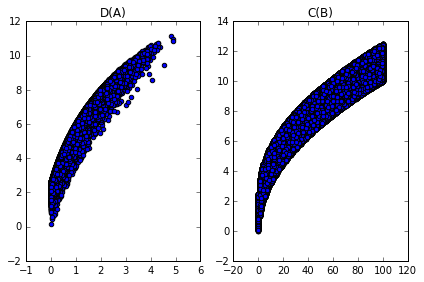

In [7]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(1,2,1)
ax1.scatter(granify_table['FEATURE_A'], granify_table['FEATURE_D'])
ax1.set_title('D(A)')

ax2 = fig2.add_subplot(1,2,2)
ax2.scatter(granify_table['FEATURE_B'], granify_table['FEATURE_C'])
ax2.set_title('C(B)')

fig2.tight_layout()
plt.show()

These look like log transformations.  I will move on by plotting the distributions for each feature in the treatment and control gorups, as well as in the conversion and no conversion groups.  This is a rough way to check for effects, but it should be interesting none the less.

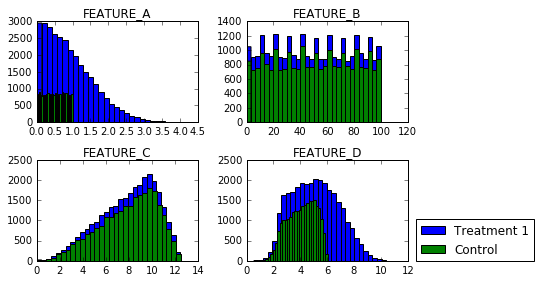

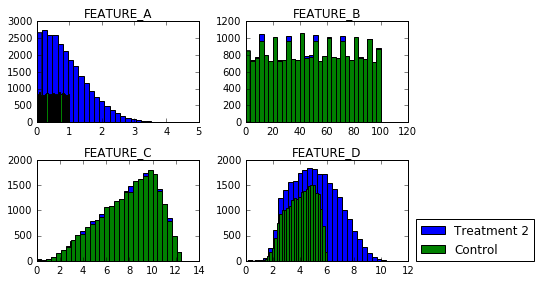

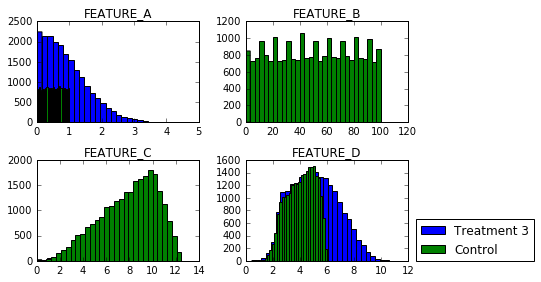

In [8]:
for treat in [1, 2, 3]: # Plot all the treatment and control distributions for each feature for each marketing strategy
    fig1 = plt.figure()
    for i in range(len(continuous_features)):  
        feat = continuous_features[i]
        ax1 = fig1.add_subplot(2,2,i+1)
    
        ax1.hist(granify_table.ix[granify_table['AD_GROUP']==treat][feat], bins=30, label = 'Treatment ' + str(treat))
        ax1.hist(granify_table.ix[granify_table['AD_GROUP']==-1][feat], bins=30, label = 'Control')
        ax1.set_title(feat)
    fig1.tight_layout()
    ax1.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.show()

This is certainly interesting, though I am not sure what to take away from it.  It looks like FEATURE_A follows a normal distribution missing its lower half, and FEATURE_B follows a uniform distribution from 0 to 100.

The difference in FEATURE_A (and FEATURE_D) between treatment and control shows that these features are not randomized. This could be an indication that this is a feature used to determine when a marketing strategy is appropriate.

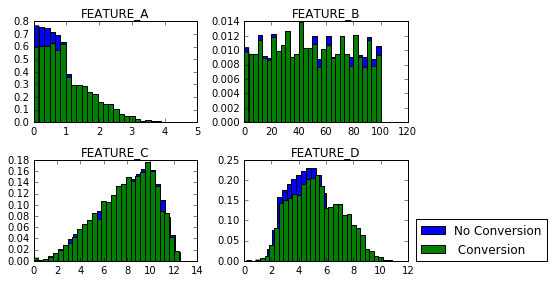

In [9]:
fig3 = plt.figure()
for i in range(len(continuous_features)):  
    feat = continuous_features[i]
    ax1 = fig3.add_subplot(2,2,i+1)
    
    ax1.hist(granify_table.ix[granify_table['CONVERSION']==0][feat], bins=30, label = 'No Conversion', normed=True)
    ax1.hist(granify_table.ix[granify_table['CONVERSION']==1][feat], bins=30, label = ' Conversion', normed=True)
    ax1.set_title(feat)
    #ax1.legend()
fig3.tight_layout()
ax1.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
plt.show()

I am not convinced that there is any difference in the distributions that could be useful to explaining the conversion rate.  The difference in the FEATURE_A distributions is probably being confounded by the difference in the treatment and control populations.

There is a lot that could be done still regarding conversion rate such as building a linear model to make more robust treatment effect measurements and to predict a user's conversion probablitity.  To wrap up this analysis I am going to have a look at the revenue and try to determine if there is an impact from your market strategies on the revenue generated on each site.

Differences in Revenue:
Treatment: 100.07947191302097 100.722579524258 3863
Control: 100.07890365448505 102.47007826502404 1204
t-value: 0.00170423429435
p-value: 0.499320194421



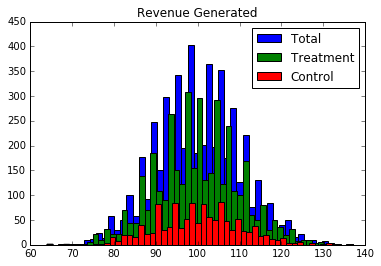

In [10]:
plotTot = plt.hist(granify_table.ix[granify_table['CONVERSION']==1].REVENUE, bins=50, label = "Total")

Exp = granify_table.ix[granify_table['GROUP'] == 'Experiment'].ix[granify_table['CONVERSION']==1].REVENUE
Con = granify_table.ix[granify_table['GROUP'] == 'Control'].ix[granify_table['CONVERSION']==1].REVENUE

print('Differences in Revenue:')
print_tp(Con, Exp)

plotExp = plt.hist(Exp, bins=50, label = "Treatment")
plotCon = plt.hist(Con, bins=50, label = "Control")
legend = plt.legend()
title = plt.title("Revenue Generated")

Nothing exciting going on really.  Going into cross-sectional analysis here may not be so benificial due to the limited data.  

If this is real data it might be interesting to dig into what is behind the spikes.  It might just be my binning choice, or it could be a handful of really popular items or price ranges.

Below I do an idealized situation with a subset that maximizes marketing strategy impact on conversions, to see if there is anything measurable in the revenue differences.  It doesn't look like the revenue is impacted, but then again the sample size isn't great.

Effect of Optimal Subset on Conversions:
Treatment: 0.10143801010493587 0.09116605611763397 5146
Control: 0.07557573791761271 0.06988671416781113 3083
t-value: 4.06968033519
p-value: 2.37918905007e-05


Effect of Optimal Subset on REVENUE:
Treatment: 100.46743295019157 106.65248821526542 522
Control: 100.23175965665236 95.2995042178481 233
t-value: 0.300929478948
p-value: 0.381800744472



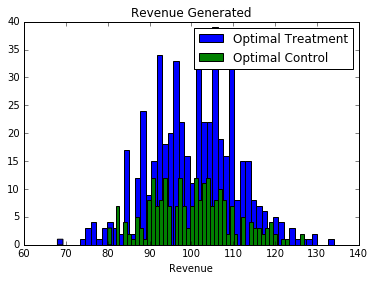

In [11]:
optimal_table = granify_table\
.ix[granify_table['AD_GROUP'] != 1]\
.ix[granify_table['SOURCE'].isin(['paid_traffic', 'social_media'])]\
.ix[granify_table['HOUR'].isin([8, 9, 11, 12, 22])]

Exp = optimal_table.ix[optimal_table['GROUP'] == 'Experiment']
Con = optimal_table.ix[optimal_table['GROUP'] == 'Control']

print('Effect of Optimal Subset on Conversions:')
print_tp(Con.CONVERSION, Exp.CONVERSION)

print()
print('Effect of Optimal Subset on REVENUE:')
print_tp(Con.ix[optimal_table['CONVERSION']==1].REVENUE, Exp.ix[optimal_table['CONVERSION']==1].REVENUE)

plotExp = plt.hist(Exp.ix[optimal_table['CONVERSION']==1].REVENUE, bins=50, label = "Optimal Treatment")
plotCon = plt.hist(Con.ix[optimal_table['CONVERSION']==1].REVENUE, bins=50, label = "Optimal Control")
legend = plt.legend()
title = plt.title("Revenue Generated")
xlab = plt.xlabel("Revenue")

# Conclusions/Summary:

    -The marketing strategy in this data set seems to be having an impact on conversion rates but not revenue.
    -The first marketing strategy doesn't seem to work.
    -People are most easily influenced just before lunchtime/
    -People who use Chrome and Safari are more easily influenced (might be an indication of software behaving poorly on the other browsers).
    -People who use android and ios aren't as easily influenced as people who use windows phone (might be an indication of poor cross platform behaviour).